In [1]:
import sys
sys.path.append("../") 

In [2]:
import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.,1.)
])

In [4]:
num_gpus = 1
model_ctx = mx.gpu()

num_workers = 2
batch_size = 64 
train_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=True).transform_first(transform),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=False).transform_first(transform),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [5]:
for X,y in train_data:
    print(X.shape)
    print(y.shape)
    break

(64, 1, 28, 28)
(64,)


### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [6]:
import mxnet as mx
from mxnet import nd, autograd, gluon
hyper={'alpha':10.}
in_units=(28,28)
out_units=10

In [7]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgd(model,model.par,step_size=0.001,ctx=model_ctx)

In [8]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgd)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


modules re-loaded


In [9]:
train_sgd=False
num_epochs=100
if train_sgd:
    par,loss=inference.fit(epochs=num_epochs,batch_size=batch_size,data_loader=train_data,verbose=True)

    fig=plt.figure(figsize=[5,5])
    plt.plot(loss,color='blue',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGD Softmax MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgd_softmax.pdf', bbox_inches='tight')
    model.net.save_parameters('softmax_sgd_'+str(num_epochs)+'_epochs.params')
else:
    model.net.load_parameters('softmax_sgd_'+str(num_epochs)+'_epochs.params',ctx=model_ctx)
    par=dict()
    for name,gluon_par in model.net.collect_params().items():
        par.update({name:gluon_par.data()})
               


In [11]:
from sklearn.metrics import classification_report

total_samples,total_labels,log_like=inference.predict(par,batch_size=batch_size,num_samples=100,data_loader=val_data)
y_hat=np.quantile(total_samples,.5,axis=0)
print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       979
           1       0.97      0.97      0.97      1133
           2       0.93      0.89      0.91      1030
           3       0.89      0.91      0.90      1008
           4       0.92      0.93      0.93       980
           5       0.85      0.88      0.86       890
           6       0.93      0.95      0.94       956
           7       0.91      0.93      0.92      1027
           8       0.88      0.87      0.87       973
           9       0.93      0.88      0.90      1008

    accuracy                           0.92      9984
   macro avg       0.92      0.92      0.92      9984
weighted avg       0.92      0.92      0.92      9984



In [13]:
from sklearn.metrics import f1_score

score=[]
for q in np.arange(.1,.9,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels),np.int32(y_hat), average='macro'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

mean f-1 : 0.8944536118845526, std f-1 : 0.05829458602691486


# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [233]:
from hamiltonian.inference.sgld import sgld

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,model.par,step_size=0.01,ctx=model_ctx)

In [234]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

modules re-loaded


In [235]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob

train_sgld=False
num_epochs=100

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='chain_nonhierarchical')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Softmax MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_softmax.pdf', bbox_inches='tight')
else:
    chain1=glob.glob("../scripts/results/softmax/chain_nonhierarchical_0_1_sgld*")
    chain2=glob.glob("../scripts/results/softmax/chain_nonhierarchical_0_sgld*")
    posterior_samples=[chain1,chain2]

In [236]:
posterior_samples_flat=[item for sublist in posterior_samples for item in sublist]

In [237]:
total_samples,total_labels,log_like=inference.predict(posterior_samples_flat,5,data_loader=val_data)

In [239]:
from sklearn.metrics import f1_score

score=[]
for q in np.arange(.1,.9,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels),np.int32(y_hat), average='macro'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

mean f-1 : 0.9006777405407332, std f-1 : 0.04194157840631061


In [92]:
import arviz as az

posterior_samples_multiple_chains=inference.posterior_diagnostics(posterior_samples)
datasets=[az.convert_to_inference_data(sample) for sample in posterior_samples_multiple_chains]
dataset = az.concat(datasets, dim="chain")
mean_r_hat_values={var:float(az.rhat(dataset)[var].mean().data) for var in model.par}
mean_ess_values={var:float(az.ess(dataset)[var].mean().data) for var in model.par}
mean_mcse_values={var:float(az.mcse(dataset)[var].mean().data) for var in model.par}

In [79]:
az.summary(dataset)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"1.weight[0,0]",-0.496,1.478,-2.993,1.342,0.867,0.687,3.0,60.0,1.83
"1.weight[0,1]",-2.072,0.963,-3.561,-0.288,0.078,0.056,151.0,132.0,1.18
"1.weight[0,2]",-2.137,0.704,-3.061,-0.540,0.149,0.147,11.0,62.0,1.14
"1.weight[0,3]",-0.169,0.714,-1.563,1.093,0.158,0.144,59.0,222.0,1.13
"1.weight[0,4]",0.265,0.833,-1.162,1.501,0.511,0.411,3.0,107.0,1.83
...,...,...,...,...,...,...,...,...,...
1.bias[5],3.268,0.810,1.617,4.547,0.283,0.239,5.0,98.0,1.32
1.bias[6],0.029,0.477,-0.916,0.814,0.038,0.027,143.0,74.0,1.03
1.bias[7],1.688,0.464,0.899,2.364,0.045,0.032,161.0,47.0,1.12
1.bias[8],-2.649,0.514,-3.663,-1.877,0.054,0.038,97.0,136.0,1.06


In [80]:
print(mean_r_hat_values)

{'1.weight': 1.453861862862687, '1.bias': 1.1607318528841408}


In [81]:
mean_ess_values

{'1.weight': 30.12714771000977, '1.bias': 64.02426545788761}

In [82]:
mean_mcse_values

{'1.weight': 0.4712754299075291, '1.bias': 0.13311773795785092}

In [240]:
from hamiltonian.psis import *

loo,loos,ks=psisloo(log_like)

In [241]:
score=[]
for q in np.arange(.1,.9,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels),np.int32(y_hat), sample_weight=1-np.clip(ks,0,1),average='weighted'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

mean f-1 : 0.8820201918859188, std f-1 : 0.05173645285626609


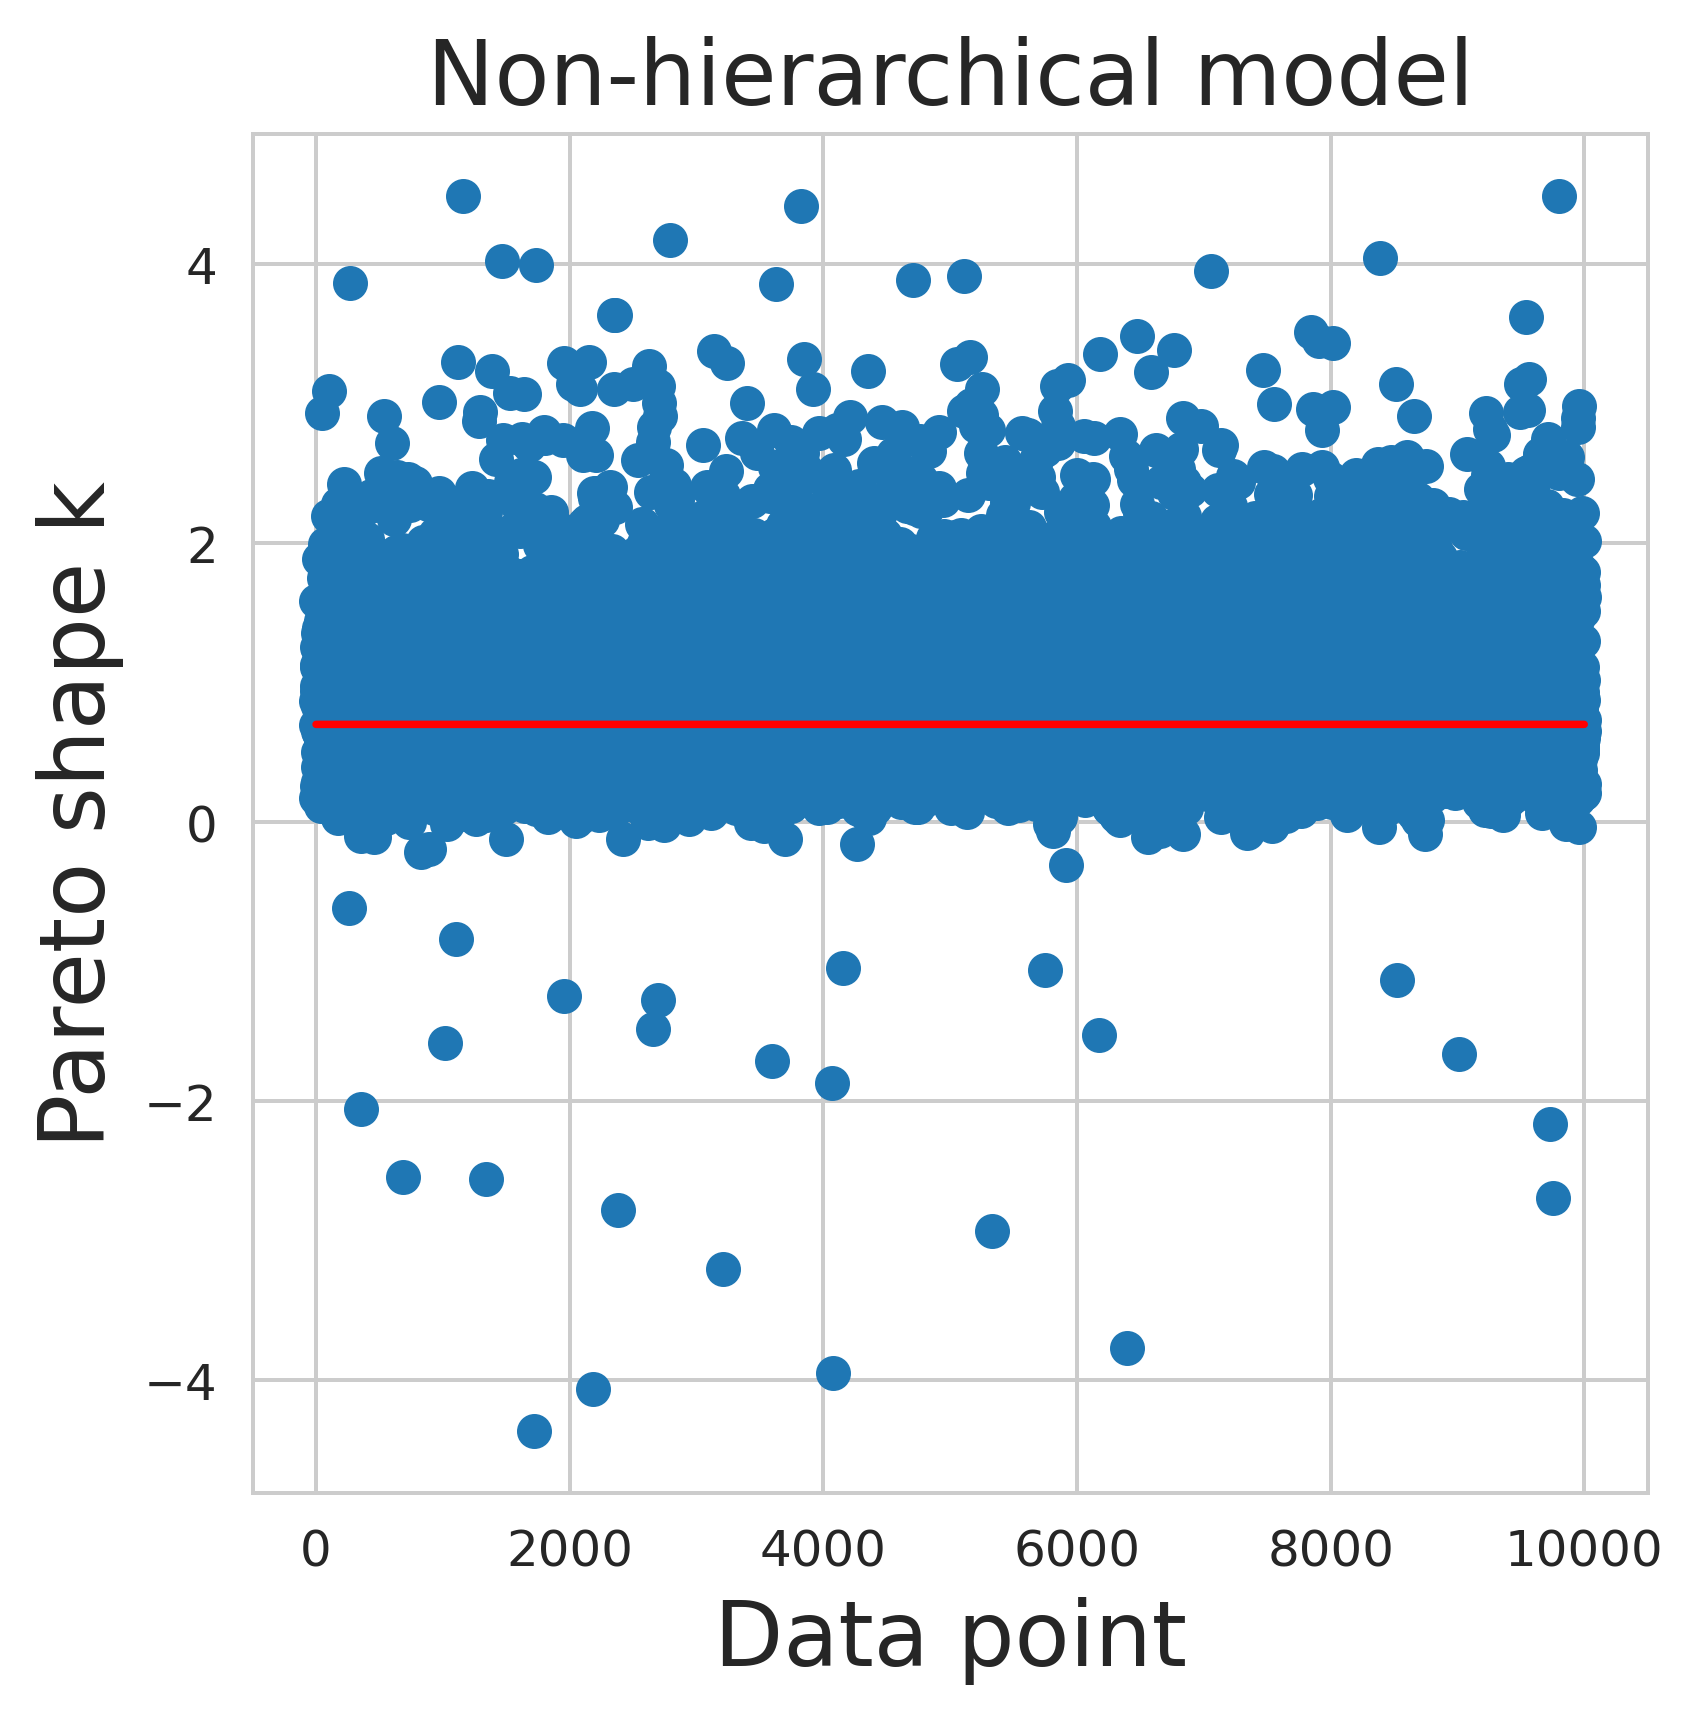

In [242]:
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")
fig=plt.figure(figsize=[5,5])
plt.scatter(list(range(len(ks))),ks)
plt.plot(list(range(len(ks))), 0.7*(np.ones(len(ks))), linestyle='-',color='red')  # solid
plt.xlabel('Data point', size=18)
plt.ylabel('Pareto shape k', size=18)
plt.title('Non-hierarchical model', size=18)
plt.savefig('psis_sgld_softmax.pdf', bbox_inches='tight')

In [118]:
np.sum(ks>1)

3814

In [119]:
ks[np.logical_and(ks>0.7,ks<1)].sum()

2077.8873194338535

In [120]:
ks[np.logical_and(ks>0.5,ks<0.7)].sum()

1112.839507347418

In [121]:
np.sum(ks<0.5)

1870

# Hierarchical Softmax <a class="anchor" id="chapter3"></a>

In [123]:
from hamiltonian.models.softmax import hierarchical_softmax
from hamiltonian.inference.sgld import sgld

model=hierarchical_softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,model.par,step_size=0.01,ctx=model_ctx)

In [132]:
train_sgld=False
num_epochs=100

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='chain_hierarchical')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Hierarchical Softmax MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_hierarchical_softmax.pdf', bbox_inches='tight')
else:
    chain1=glob.glob("../scripts/results/softmax/chain_hierarchical_0_1_sgld*")
    chain2=glob.glob("../scripts/results/softmax/chain_hierarchical_0_sgld*")
    posterior_samples=[chain1,chain2]

In [133]:
posterior_samples_flat=[item for sublist in posterior_samples for item in sublist]

In [166]:
total_samples,total_labels,log_like=inference.predict(posterior_samples_flat,5,data_loader=val_data)

In [193]:
from sklearn.metrics import f1_score

score=[]
for q in np.arange(.1,.9,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels),np.int32(y_hat), average='micro'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

mean f-1 : 0.9012125, std f-1 : 0.04060030018361933


In [104]:
import arviz as az

posterior_samples_multiple_chains=inference.posterior_diagnostics(posterior_samples)
datasets=[az.convert_to_inference_data(sample) for sample in posterior_samples_multiple_chains]
dataset = az.concat(datasets, dim="chain")
mean_r_hat_values={var:float(az.rhat(dataset)[var].mean().data) for var in model.par}
mean_ess_values={var:float(az.ess(dataset)[var].mean().data) for var in model.par}
mean_mcse_values={var:float(az.mcse(dataset)[var].mean().data) for var in model.par}

In [105]:
az.summary(dataset)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"1.weight[0,0]",-0.435,0.559,-1.392,0.534,0.050,0.036,123.0,188.0,1.03
"1.weight[0,1]",-0.538,0.454,-1.575,0.331,0.030,0.077,159.0,199.0,1.14
"1.weight[0,2]",-0.024,1.951,-2.739,2.450,1.260,1.030,3.0,137.0,1.82
"1.weight[0,3]",-0.790,0.887,-2.373,0.713,0.369,0.275,6.0,150.0,1.30
"1.weight[0,4]",-0.142,0.515,-0.970,0.821,0.089,0.063,40.0,153.0,1.05
...,...,...,...,...,...,...,...,...,...
1.bias[5],0.733,0.204,0.352,1.079,0.014,0.010,220.0,188.0,1.00
1.bias[6],-0.097,0.168,-0.413,0.209,0.012,0.009,191.0,222.0,1.01
1.bias[7],0.222,0.191,-0.121,0.554,0.018,0.013,107.0,177.0,1.03
1.bias[8],-0.577,0.197,-0.903,-0.223,0.014,0.010,206.0,181.0,1.01


In [106]:
print(mean_r_hat_values)

{'1.weight': 1.4332045249044332, '1.bias': 1.0199921438570798}


In [107]:
print(mean_ess_values)

{'1.weight': 37.230947618370244, '1.bias': 152.9534624842127}


In [108]:
print(mean_mcse_values)

{'1.weight': 0.45091424917665746, '1.bias': 0.017297085878885902}


In [179]:
loo,loos,ks=psisloo(log_like)

In [221]:
score=[]
for q in np.arange(.1,.9,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels[ks>0.7]),np.int32(y_hat[ks>0.7]), average='macro'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

mean f-1 : 0.9061102858180154, std f-1 : 0.04252525837369968


In [231]:
score=[]
for q in np.arange(.1,.9,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels[ks<0.7]),np.int32(y_hat[ks<0.7]), average='macro'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

mean f-1 : 0.8751571228863063, std f-1 : 0.047568564597113595


In [232]:
score=[]
for q in np.arange(.1,.9,.1):
    y_hat=np.quantile(total_samples,q,axis=0)
    score.append(f1_score(np.int32(total_labels),np.int32(y_hat), sample_weight=1-np.clip(ks,0,1),average='weighted'))
print('mean f-1 : {0}, std f-1 : {1}'.format(np.mean(score),2*np.std(score)))

mean f-1 : 0.8805298134535413, std f-1 : 0.047596517455835645


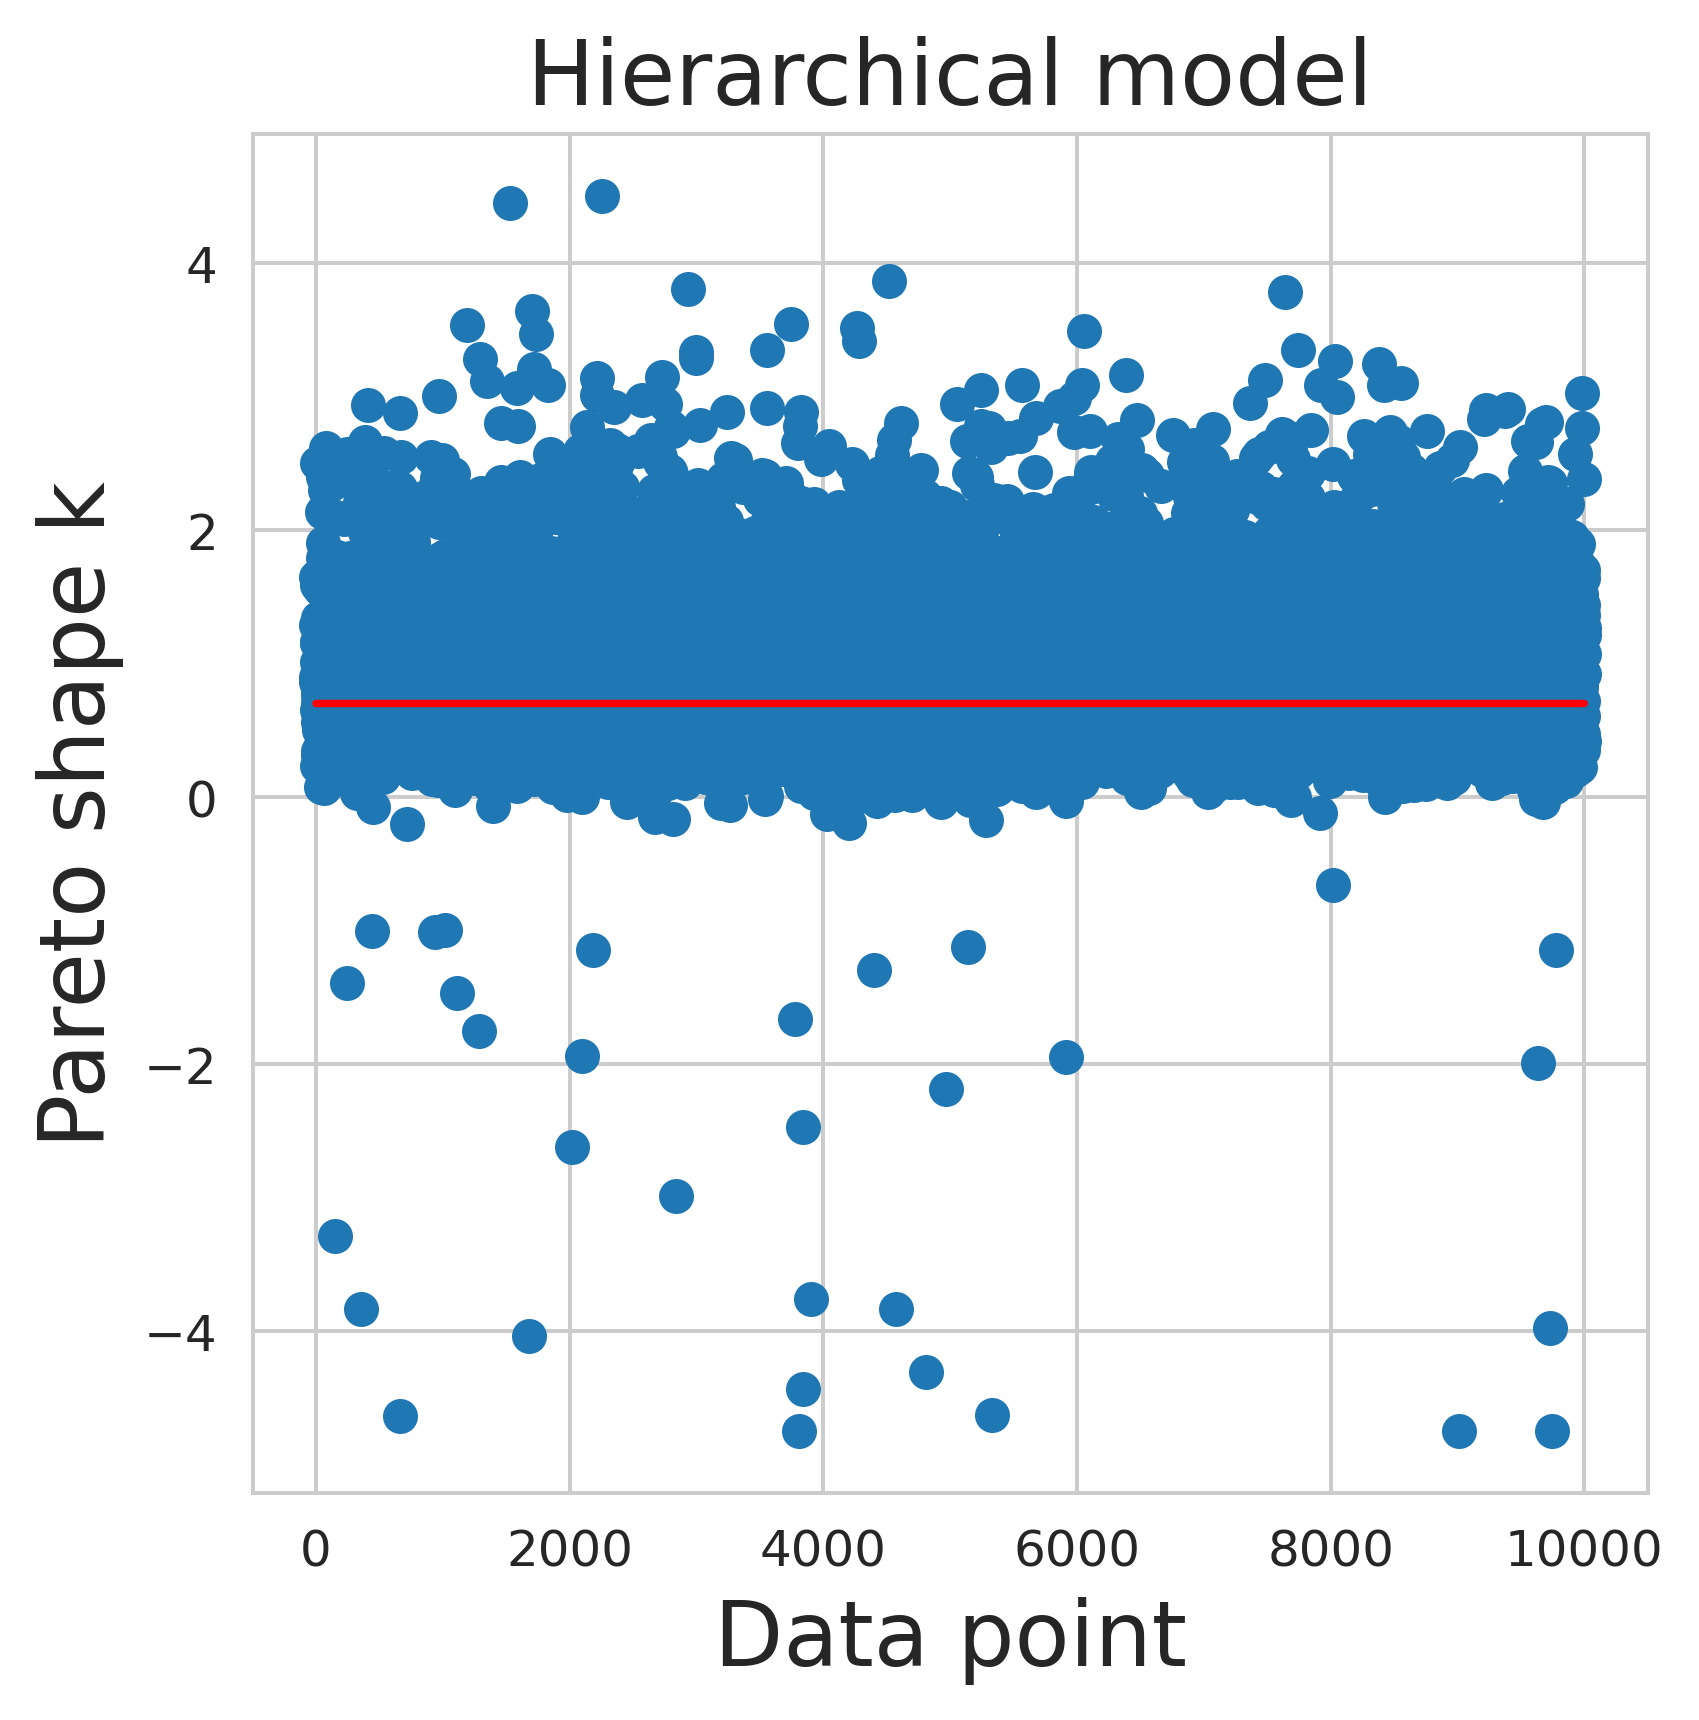

In [220]:
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")
fig=plt.figure(figsize=[5,5])
plt.scatter(list(range(len(ks))),ks)
plt.plot(list(range(len(ks))), 0.7*(np.ones(len(ks))), linestyle='-',color='red')  # solid
plt.xlabel('Data point', size=18)
plt.ylabel('Pareto shape k', size=18)
plt.title('Hierarchical model', size=18)
plt.savefig('psis_sgld_hierarchical_softmax.pdf', bbox_inches='tight')

In [188]:
np.sum(ks>1)

3721

In [189]:
ks[np.logical_and(ks>0.7,ks<1)].sum()

2147.3750137939246

In [190]:
ks[np.logical_and(ks>0.5,ks<0.7)].sum()

1137.7001659693447

In [191]:
np.sum(ks<0.5)

1839